In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
import gym
import gym_minigrid

import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict, deque
from random import random

from minigrid_wrappers import CoordsObsWrapper, FourDirectionsActionWrapper, RewardWrapper
from utils import render

# Getting Started with OpenAI Gym

## Interface

### Attributes
`action space`

`observation space`

### Methods
`def step`

`def reset`

`def render`

### Wrappers

## Gym Minigrid 
https://github.com/maximecb/gym-minigrid

## Example Minigrid Environments
<ol>
    <li>MiniGrid-Empty-8x8-v0</li>
    <li>MiniGrid-DistShift1-v0</li>
    <li>MiniGrid-DistShift2-v0</li>
    <li>MiniGrid-LavaCrossingS9N3-v0</li>
</ol>

Actions in the basic Minigrid environment:
<ol>
<li>Turn left</li>
<li>Turn right</li>
<li>Move forward</li>
<li>Pick up an object</li>
<li>Drop the object being carried</li>
<li>Toggle (open doors, interact with objects)</li>
<li>Done (task completed, optional)</li>
</ol>

In [ ]:
env = gym.make("MiniGrid-DistShift1-v0") # create environment

In [ ]:
env.action_space # action space of the environment

In [ ]:
env.observation_space # observation space of the environment

In [ ]:
obs = env.reset() # reset and get an initial observation
for _ in range(100):
    action = env.action_space.sample() # sample a random action from the action space
    obs, reward, done, _ = env.step(action) # perform the action and receive an observation, reward, and if the episode is done
    render(env) # render the environment
    if done: # if the episode has terminated
        env.reset() # reset the environment

# Policy Evaluation

## Monte Carlo Policy Evaluation

TODO: explain monte carlo policy evaluation.
add notes, pictures, equations

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def MCPE(episodes, env):
    returns = np.zeros((env.height, env.width))
    v_count = np.zeros((env.height, env.width))
    value_function = np.ones((env.height, env.width))*-2
    
    for i in tqdm(range(episodes), ncols=0):
        rewards = []
        states = []
        state = env.reset()
        done = False

        states.append(state)
        while not done:
            state, reward, done, _ = env.step(env.action_space.sample())
            states.append(state)
            rewards.append(reward)
       
        G = 0
        for state, reward in zip(states[:-1], rewards[::-1]):
            G += reward
            v_count[state] += 1
            returns[state] += G
        
        if i % 10 == 0:
            clear_output(wait = True)
            ax = sns.heatmap(value_function,cmap='RdYlGn', linewidth=1)
            plt.pause(0.00001)
        
        value_function = np.round(returns/v_count, 3)

    return np.round(returns/v_count, 3)

In [ ]:
env = gym.make("MiniGrid-DistShift1-v0") # create environment
env = CoordsObsWrapper(env) # wrap to get coordinates of agent as observation
env = FourDirectionsActionWrapper(env) # wrap to simplify action space (4 directional movement)
render(env)

In [ ]:
value_function = MCPE(1000, env)

In [ ]:
print(value_function)

## Temporal Difference Policy Evaluation

# Control

In [9]:
class Agent:
    """
    Base Agent class
    """
    def __init__(self,
                 env_name,
                 learning_rate=0.005,
                 eps_start = 0.5,
                 eps_end= 0.1,
                 eps_end_episode = 250,
                 episodes=1000,
                 gamma=0.9):
        
        self.env_name = env_name
        self.env = self.create_env(env_name)
        self.learning_rate = learning_rate
        
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_end_episode = eps_end_episode        
        
        self.gamma = gamma
        self.episodes = episodes
        num_actions = self.env.action_space.n
        self.table = defaultdict(lambda: np.zeros(shape=(num_actions,)))
        self.rolling_mean = deque(np.zeros(shape=5), maxlen=5)
        self.rolling_mean_history = []
        self.epsilon_history = []
        
    def get_epsilon(self, episode):
        return max(self.eps_end, self.eps_start
              - (episode + 1) / self.eps_end_episode)
        
    def create_env(self, env_name):
        env = gym.make(env_name)
        env = RewardWrapper(env)
        env = CoordsObsWrapper(env)
        env = FourDirectionsActionWrapper(env)
        return env        

    def e_greedy(self, state, epsilon):
        if random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.table[state])

    def train(self):
        raise NotImplementedError
        
    def plot(self):
        clear_output(wait = True)    
        plt.plot(np.array(agent.rolling_mean_history))
        plt.plot(self.epsilon_history)
        plt.pause(0.00001) 

    def demo(self, epsilon):
        print('Demo')
        done = False
        state = self.env.reset()
        for i in range(5):
            print(i)
            while not done:
                action = self.e_greedy(state,epsilon)
                next_state, reward, done, _ = self.env.step(action)
                self.rolling_mean.append(reward)
                state = next_state
                render(self.env)
            state = self.env.reset()
            done = False

## SARSA

Training a SARSA agent

TODO: add some notes, pictures, equations of SARSA

In [10]:
class AgentSarsa(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def update_sarsa(self, action, state, next_state, next_action, reward):
        self.table[state][action] += self.learning_rate*(
            reward + self.gamma*self.table[next_state][next_action] - self.table[state][action])

    def train(self):
        done = False
        state = self.env.reset()
        action = self.e_greedy(state, self.get_epsilon(0))

        episode_reward = 0
        for ep in range(self.episodes):
            epsilon = self.get_epsilon(ep)
            while not done:
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                next_action = self.e_greedy(next_state, epsilon)
                self.update_sarsa(action, state, next_state,
                                  next_action, reward)
                state = next_state
                action = next_action
            state = self.env.reset()
            action = self.e_greedy(state, epsilon)
            done = False
            self.rolling_mean.append(episode_reward)
            episode_reward = 0
            self.rolling_mean_history.append(np.mean(self.rolling_mean))
            self.epsilon_history.append(epsilon)
            
            self.plot()

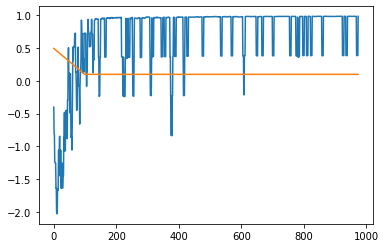

In [ ]:
agent = AgentSarsa(env_name='MiniGrid-DistShift1-v0')
agent.train()

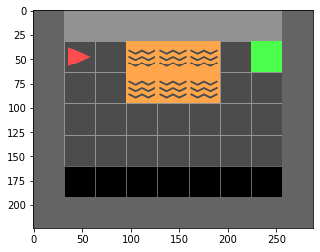

TypeError: unhashable type: 'dict'

In [8]:
plt.close()
agent.demo(0)

## Q-learning

Training a Q-learning agent

//TODO:
add some notes and theory about Q-learning

In [ ]:
class AgentQL(Agent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def update_q_table(self, action, state, next_state, reward):
        self.table[state][action] += self.learning_rate*(
            reward + self.gamma*np.max(self.table[next_state]) - self.table[state][action])

    def train(self):
        done = False
        state = self.env.reset()
        step = 0
        episode_reward = 0
        for ep in range(self.episodes):
            epsilon = self.get_epsilon(ep)
            while not done:
                action = self.e_greedy(state, epsilon)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                self.update_q_table(action, state, next_state, reward)
                state = next_state
                step += 1
            state = self.env.reset()
            done = False
            self.rolling_mean.append(episode_reward)
            episode_reward = 0
            self.rolling_mean_history.append(np.mean(self.rolling_mean))
            self.epsilon_history.append(epsilon)
            
            self.plot()

In [ ]:
agent = AgentQL(env_name='MiniGrid-DistShift1-v0')
agent.train()

In [ ]:
agent.demo(0)